## Background
The marketing team of an e-commerce site has launched an email campaign. This site has email
addresses from all the users who created an account in the past.
They have chosen a random sample of users and emailed them. The email let the user know
about a new feature implemented on the site. From the marketing team perspective, a success
is if the user clicks on the link inside of the email. This link takes the user to the company site.
You are in charge of figuring out how the email campaign performed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_curve, classification_report,precision_score,recall_score

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif

from sklearn.model_selection import train_test_split
import xgboost as xgb

import warnings
warnings.simplefilter('ignore')

# 1. Load Dataset

In [2]:
# import email_table.csv
df_original = pd.read_csv('email_table.csv')
df_original.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [3]:
df = df_original.copy()
df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [4]:
# basic information
df.isnull().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   email_id             100000 non-null  bool 
 1   email_text           100000 non-null  bool 
 2   email_version        100000 non-null  bool 
 3   hour                 100000 non-null  bool 
 4   weekday              100000 non-null  bool 
 5   user_country         100000 non-null  bool 
 6   user_past_purchases  100000 non-null  bool 
dtypes: bool(7)
memory usage: 683.7 KB


In [5]:
# check missing values
df.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [6]:
# import email_opened_table.csv
df_original_email_opened = pd.read_csv('email_opened_table.csv')
df_email_opened = df_original_email_opened.copy()
df_email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [7]:
# basic information
df_email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [8]:
# check missing values
df_email_opened.isnull().sum()

email_id    0
dtype: int64

In [9]:
# import link_clicked_table.csv
df_original_link_clicked = pd.read_csv('link_clicked_table.csv')
df_link_clicked = df_original_link_clicked.copy()
df_link_clicked.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [10]:
# basic information
df_link_clicked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


In [11]:
# check missing values
df_link_clicked.isnull().sum()

email_id    0
dtype: int64

In [12]:
# check uniqueness of email_id in three tables
print('email_table.csv: ', len(df['email_id'].unique()))
print('email_opened_table.csv: ', len(df_email_opened['email_id'].unique()))
print('link_clicked_table.csv: ', len(df_link_clicked['email_id'].unique()))

email_table.csv:  100000
email_opened_table.csv:  10345
link_clicked_table.csv:  2119


# 2. Data Processing

In [13]:
# merge three table into one

# create a new column for "df_email_opened"
df_email_opened['opened'] = 1

# create a new column for "df__link_clicked"
df_link_clicked['clicked'] = 1

# merge
df = pd.merge(left = df, right = df_email_opened, how = 'left', on = 'email_id')
df = pd.merge(left = df, right = df_link_clicked, how = 'left', on = 'email_id')

# fill NA with 0
df = df.fillna(value = 0)

df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


In [14]:
# change column 'opened' and 'clicked' into integer
df['opened'] = df['opened'].astype(int)
df['clicked'] = df['clicked'].astype(int)
df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


# Question 01
##### What percentage of users opened the email and what percentage clicked on the link within the email?

In [15]:
print(f"The percentage of users opened the email: {df['opened'].mean()*100}%")
print(f"The percentage clicked on the link within the email: {df['clicked'].mean()*100}%")

The percentage of users opened the email: 10.345%
The percentage clicked on the link within the email: 2.119%


# Question 02
#####  Did you find any interesting pattern on how the email campaign performed for different segments of users?

## EDA

* EDA help us understand the data

In [16]:
# check if our target variable is imbalanced 
clicked_dist = df['clicked'].value_counts(normalize=True)
clicked_dist

0    0.97881
1    0.02119
Name: clicked, dtype: float64

* As we can see above, it is **highly imbalanced**

### Chi-Square test
 * Chi-Square help us find which feature have great impact on click rate

In [17]:
# convert string to number for checking feature importance in the futrue
email_text_encoder = LabelEncoder()
email_version_encoder = LabelEncoder()
user_countryl_encoder = LabelEncoder()

df_ch2 = df.copy()

df_ch2['email_text'] = email_text_encoder.fit_transform(df_ch2['email_text'])
df_ch2['email_version'] = email_text_encoder.fit_transform(df_ch2['email_version'])
df_ch2['user_country'] = email_text_encoder.fit_transform(df_ch2['user_country'])

df_ch2['weekday'] = df_ch2['weekday'].map({"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7})

In [18]:
df_ch2.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,1,1,2,7,3,5,0,0
1,966622,0,1,12,7,2,2,1,1
2,777221,0,1,11,3,3,2,0,0
3,493711,1,0,6,1,2,1,0,0
4,106887,0,0,14,1,3,6,0,0


In [19]:
colnames = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
X = df_ch2.loc[:,colnames]
y = df_ch2['clicked']
ch2values, p_value = chi2(X, y)
pd.DataFrame({'chi2_value':ch2values,'p-value':p_value},index = colnames).sort_values(by='p-value')

,chi2_value,p-value
user_past_purchases,2928.424627,0.000000e+00
email_version,89.446479,3.150472e-21
user_country,70.149639,5.497210e-17
weekday,52.300232,4.763182e-13
hour,26.552637,2.564544e-07
email_text,17.241715,3.291296e-05


As we can see above,

* The important features: 'user_past_purchases', 'email_version', and 'user_country'
* Relatively, not that important features: 'weekday', 'hour', and 'email text'

### I. Visualization of user_past_purchases
*  how many items in the past were bought by the user receiving the email

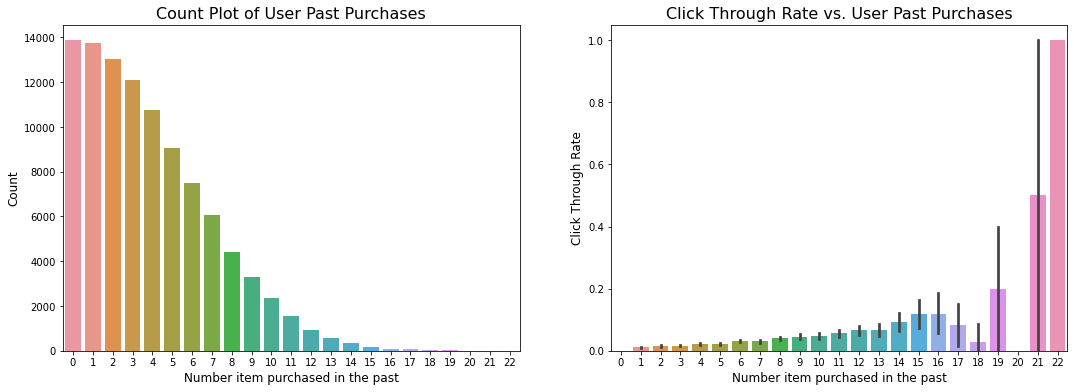

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='user_past_purchases',data=df, ax=ax[0])
ax[0].set_xlabel('Number item purchased in the past', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)


sns.barplot(x='user_past_purchases', y='clicked',data=df, ax=ax[1])
ax[1].set_xlabel('Number item purchased in the past', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.show()

In the above plots,
* the number of purchases is **positively correlated** with the click-through rate. Especially when the purchase is more than 20 times, the click-through rate increases significantly
* When the number of purchases are 17 and 18, the click-through rate decreased. Maybe because there are not enought sample size, so our company only captured this gorup of users who are unwilling to click. But we need further investigation 
* There is no any click when the number of purchases is 20, and it is very unusual. Maybe there are some technical issues prevent customers from clicking, or because the numbers of this group users are too small, so our company just happened not to send any emails to this group of users

### II. Visualization of email_version
*   Some emails were "personalized" (i.e. they had the name of the user receiving the email in the incipit, such as "Hi John,"), while some emails were "generic" (the incipit was just "Hi,").

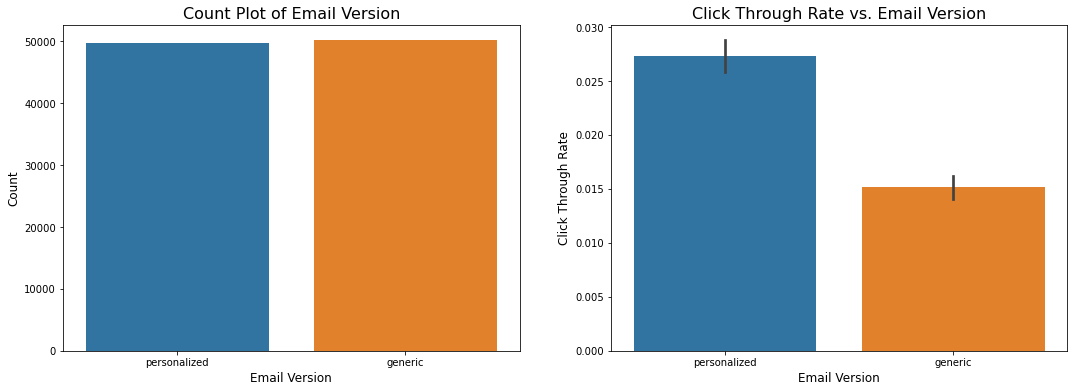

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='email_version',data=df, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)


sns.barplot(x='email_version', y='clicked',data=df, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.show()

In the above plots,
* It is clear that **personalized emails** can bring higher click-through rate

### III. Visualization of user_country
*   The country where the user receiving the email was based. It comes from the user ip address when user created the account.

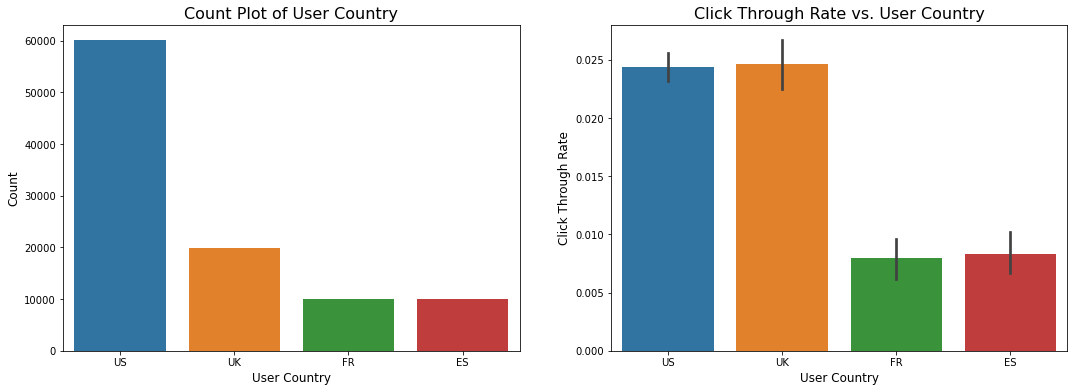

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='user_country',data=df, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)


sns.barplot(x='user_country', y='clicked',data=df, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.show()

In the above plots,
* **US** and **UK** users have the highest click-through rate

### IV. Visualization of weekday
*   The day when the email was sent.

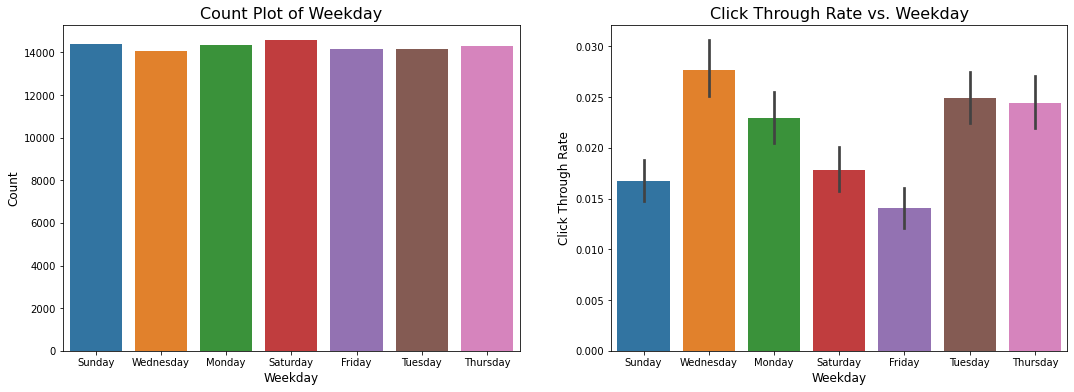

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='weekday',data=df, ax=ax[0])
ax[0].set_xlabel('Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Weekday', fontsize=16)


sns.barplot(x='weekday', y='clicked',data=df, ax=ax[1])
ax[1].set_xlabel('Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Weekday', fontsize=16)
plt.show()

In the above plots,
* **Wednesday** have the highest click-through rate
* The click-through rate of **Tuesday** and **Thursday** are also very high

### V. Visualization of hour
*   The user local time when the email was sent.

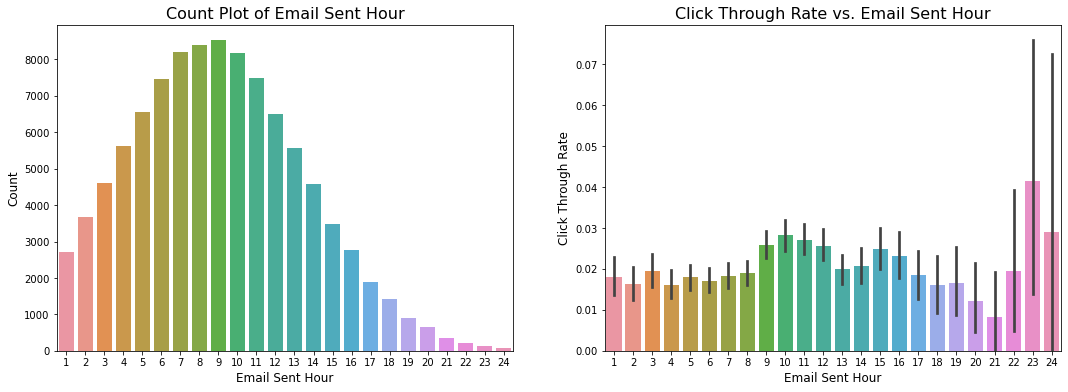

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='hour',data=df, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)


sns.barplot(x='hour', y='clicked',data=df, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.show()

In the above plots,
* When the emails are sent between **23 to 24 o'clock**, our company receives the highest click-through rate 

### VI. Visualization of email_text
*   There are two versions of the email: one has "long text" (i.e. has 4 paragraphs) and one has "short text" (just 2 paragraphs)

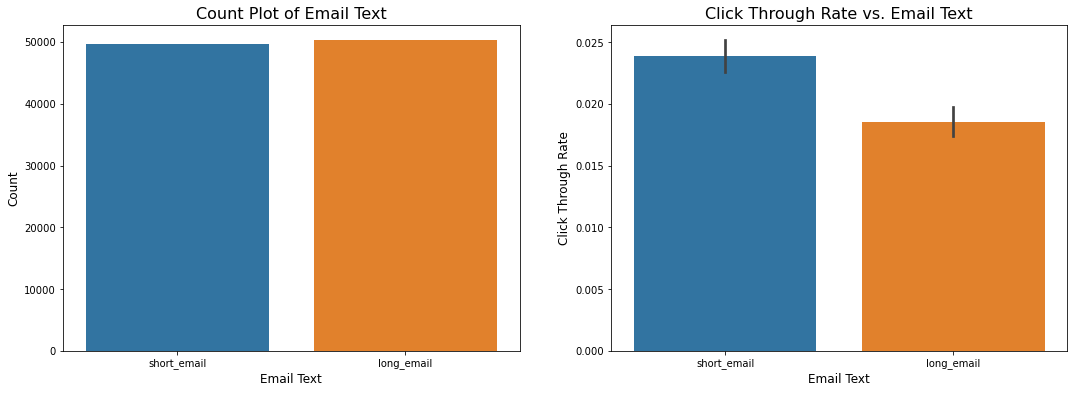

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='email_text',data=df, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)


sns.barplot(x='email_text', y='clicked',data=df, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.show()

In the above plots,
* It is clear that **"short text" email** can bring higher click-through rate

# Question 03
* Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?


## Machine Learning Model
* We will use XGboost

### (1) Prepare data

In [26]:
## we use the df_ch2 dataset since all types are numeric
df_ch2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   email_id             100000 non-null  int64
 1   email_text           100000 non-null  int32
 2   email_version        100000 non-null  int32
 3   hour                 100000 non-null  int64
 4   weekday              100000 non-null  int64
 5   user_country         100000 non-null  int32
 6   user_past_purchases  100000 non-null  int64
 7   opened               100000 non-null  int32
 8   clicked              100000 non-null  int32
dtypes: int32(5), int64(4)
memory usage: 5.7 MB


In [27]:
df_for_model = df_ch2.copy()

In [28]:
# create new column to see if the weekend has better performance
df_for_model['is_weekend'] = (df_for_model['weekday'] >=5).astype(int)

# we add categorical 'user_country' column to our df_for_model for One-Hot-Encode
df_for_model['country'] = df['user_country']

In [29]:
# set X and y
X = df_for_model.loc[:,["country","user_past_purchases","email_text","email_version","is_weekend"] ]
y = df_for_model.loc[:,"clicked"]

In [30]:
# conduct One-Hot-Encode on 'country' column
X = pd.get_dummies(X,columns=["country"],drop_first=True)

In [31]:
# split for training and testing, 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

### (2) Train XGBoost

In [32]:
# We convert data to DMatrix, DMatrix is an internal data structure which is optimized for both memory efficiency and training speed.
train_matrix = xgb.DMatrix(X_train,y_train)
test_matrix = xgb.DMatrix(X_test)

### k-fold Cross Validation in XGBoost

In [33]:
params = {}
params['objective'] = 'binary:logistic'  # output probabilities
params['metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(dtrain=train_matrix, 
                    params=params, 
                    nfold=5,
                    num_boost_round = params["num_rounds"],
                    metrics = params['metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = 11)

[15:02:54] WARNING: ..\src\learner.cc:573: 
Parameters: { "early_stopping_rounds", "metric", "num_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:02:54] WARNING: ..\src\learner.cc:573: 
Parameters: { "early_stopping_rounds", "metric", "num_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:02:54] WARNING: ..\src\learner.cc:573: 
Parameters: { "early_stopping_rounds", "metric", "num_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameter

In [34]:
n_best_trees = cv_results.shape[0]
print(f"best number of trees: {n_best_trees}")

best number of trees: 56


In [35]:
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[15:03:08] WARNING: ..\src\learner.cc:573: 
Parameters: { "early_stopping_rounds", "metric", "num_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:03:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.60617
[1]	train-logloss:0.53478
[2]	train-logloss:0.47549
[3]	train-logloss:0.42559
[4]	train-logloss:0.38306
[5]	train-logloss:0.34669
[6]	train-logloss:0.31526
[7]	train-logloss:0.28807
[8]	train-logloss:0.26438
[9]	train-logloss:0.24382
[10]	train-logloss:0.22577
[11]	train-logloss:0.21008
[12]	train-logloss:0.19630
[13]	train-logloss:0.18404
[14]	train-lo

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

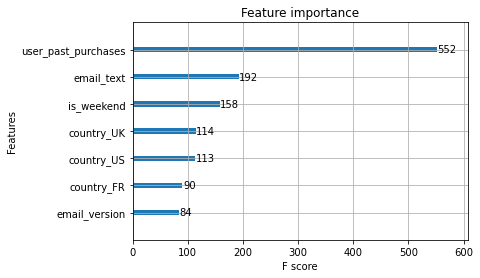

In [36]:
# plot feature importances
xgb.plot_importance(gbt)

In [37]:
print('Click rate: ', df_for_model['clicked'].value_counts()[1]/len(df_for_model))

Click rate:  0.02119


### Plot ROC curve and choose better probability threshold
* Our target variable is highly imbalanced, click rate is only 2%. If we use default probability threshold which is 0.5, the model will classify every example as negative, so we need to choose a better probability threshold. 
*  We need to plot the ROC curve, but ROC cannot be plot on either training set or test set. So, we have to split the train dataset into 'training' and 'validation' sets, and train our model again and plot ROC on 'validation' set.

In [38]:
# split the train dataset into 'training' and 'validation' sets. 80% train, 20% test.
X_train_roc_plot,X_valid,y_train_roc_plot,y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=11)

# convert data to DMatrix
train_only_matrix = xgb.DMatrix(X_train_roc_plot,y_train_roc_plot)
valid_matrix = xgb.DMatrix(X_valid)
    
# training model
gbt_train_only = xgb.train(params, train_only_matrix, n_best_trees)
    
# prediction
y_valid_pred = gbt_train_only.predict(valid_matrix, ntree_limit=n_best_trees)

# create ROC curce and AUC
valid_fpr, valid_tpr, valid_threshold = roc_curve(y_valid,y_valid_pred)
valid_auc = np.round(auc(valid_fpr, valid_tpr), 3)

[15:03:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "early_stopping_rounds", "metric", "num_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:03:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


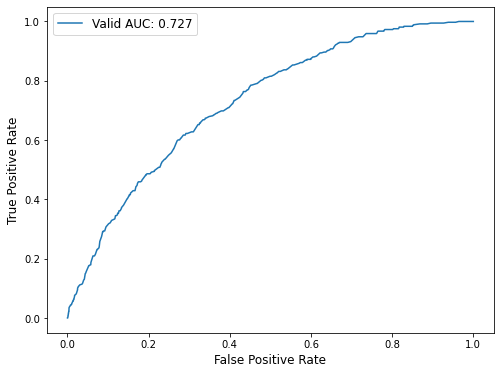

In [39]:
# ROC curves and AUC plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(valid_fpr, valid_tpr, label='Valid AUC: ' + str(valid_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

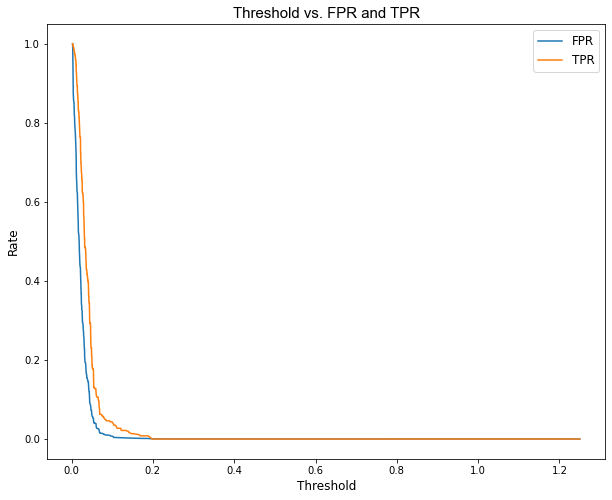

In [54]:
# Shows the correlation between thresholds and FPR & TPR
roc_results01 = {'FPR': valid_fpr, 'TPR': valid_tpr, 'Threshold': valid_threshold}
roc_results01 = pd.DataFrame(roc_results01)

# plot
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(roc_results01['Threshold'], roc_results01['FPR'],label='FPR')
ax.plot(roc_results01['Threshold'], roc_results01['TPR'],label='TPR')
plt.title('Threshold vs. FPR and TPR', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

* Try to balance Precision and Recall, we can choose the new threshold that  "True Positive Rate" is around 0.625, then "False Positive Rate" will be around 0.3

In [56]:
pick_threshold = {
    "valid_fpr": valid_fpr, 
    "valid_tpr": valid_tpr, 
    "valid_threshold": valid_threshold
}

# take a look at the threshold when True Positive Rate is around 0.6
df_pick_threshold = pd.DataFrame(pick_threshold)
df_pick_threshold.loc[(df_pick_threshold['valid_tpr'] > 0.6) & (df_pick_threshold['valid_tpr'] < 0.65),:]

,valid_fpr,valid_tpr,valid_threshold
205,0.272774,0.600543,0.029202
206,0.273414,0.600543,0.029037
207,0.276292,0.600543,0.028834
208,0.278787,0.605978,0.028684
209,0.279427,0.605978,0.028650
210,0.285504,0.616848,0.028488
211,0.286016,0.616848,0.028470
212,0.286847,0.616848,0.028465
213,0.289342,0.616848,0.028257
214,0.289918,0.616848,0.028089


In [57]:
# choose a threshold based on ROC
# FPR=0.310133, TPR=0.627717, Threshold=0.026351
y_train_pred01 = gbt.predict(train_matrix, ntree_limit=n_best_trees)
new_threshold=0.026351
y_train_pred = y_train_pred01 > new_threshold
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81     78286
           1       0.04      0.68      0.08      1714

    accuracy                           0.68     80000
   macro avg       0.52      0.68      0.45     80000
weighted avg       0.97      0.68      0.79     80000



In [46]:
# choose a threshold based on ROC
# FPR=0.310133, TPR=0.627717, Threshold=0.026351
y_test_pred01 = gbt.predict(test_matrix, ntree_limit=n_best_trees)
new_threshold=0.026351
y_test_pred = y_test_pred01 > new_threshold
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81     19595
           1       0.04      0.65      0.08       405

    accuracy                           0.69     20000
   macro avg       0.52      0.67      0.44     20000
weighted avg       0.97      0.69      0.80     20000



In [47]:
print(f"test precision: {precision_score(y_test,y_test_pred) * 100:.2f}%")
print(f"test recall: {recall_score(y_test,y_test_pred) * 100:.2f}%")

test precision: 4.10%
test recall: 64.94%


#### Answer the testion03: can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

In [48]:
n_emails_old_sent = y_test_pred.shape[0]
n_emails_new_sent = y_test_pred.sum()
saving_percentage = 100 - n_emails_new_sent * 100.0/n_emails_old_sent
print(f"Number of emails sent in old way: {n_emails_old_sent}\
      \nNumber of emails sent in new way: {n_emails_new_sent}\
      \nSaving percentage (%): {saving_percentage}")

Number of emails sent in old way: 20000      
Number of emails sent in new way: 6411      
Saving percentage (%): 67.945


* my model only need to send 33% of the old email amount, saving 67% amount.
* my model will cover almost 65% of valued users which will click the link. (test recall: 64.94%)

# Question 04
* By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

In [49]:
print(f"The new click through rate: {precision_score(y_test,y_test_pred) * 100:.1f}%")

The new click through rate: 4.1%


* Answer: The new click through rate is 4.1%. Compare with the old click through rate (2.12%) , the new click through rate is creased **1.98%**

##### How would you test that?

To test my conclusion, we need to perform a A/B test:

1. Randomly assign users to two groups, Control group and Experiment group.
2. In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
3. In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
4. Then we preform a one-tail unpaired t-test to test whether Experiement group's click through rate is higher than Control group's click through rate.